In [1]:
%matplotlib notebook
from IPython.display import Image

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [2]:
import h5py
import torch
import numpy as np

from sklearn import decomposition

from orthonet import jacob

## Quickly check out data

In [3]:
BASE_PATH = '/u/xl/tjlane/cryoem/dynanet/particle_simulations/ortho/mnist/'

test = torch.load(BASE_PATH + 'data/MNIST/processed/test.pt')

original_data = test[0].numpy()
class_labels  = test[1]

plt.figure()
plt.imshow(original_data[47])
plt.show()

<IPython.core.display.Javascript object>

### Load Data & Model

In [4]:
def load_model(model_path, original_data):

    model = torch.load(model_path + '/model.pt')

    ot = torch.tensor(original_data.astype(np.float32))
    latent = model.encode(ot).detach().numpy()
    recon  = model(ot)

    # deals with VAE case where I also saved logvar, use only mu here
    if type(recon) == tuple:
        recon = recon[0].detach().numpy()
    else:
        recon = recon.detach().numpy()

    return model, latent, recon

MODEL_PATH = BASE_PATH + 'ortho_mnistvae-1.00e+00_ob1.00e+00_db1.00e+09'
model, latent, recon = load_model(MODEL_PATH, original_data)

/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'orthonet.models.MnistVAE' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


### Take a look at the training curves and direct latent space

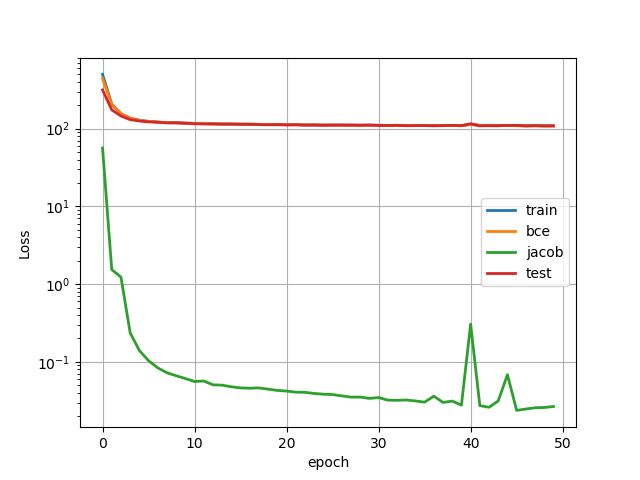

In [5]:
Image(filename=MODEL_PATH + '/loss_curves.png')

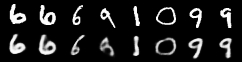

In [6]:
Image(filename=MODEL_PATH + '/reconstructions/reconstruction_48.png')

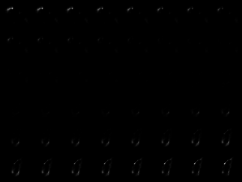

In [7]:
Image(filename=MODEL_PATH + '/z0.png')

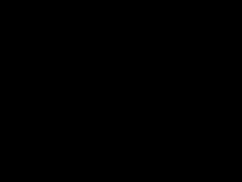

In [8]:
Image(filename=MODEL_PATH + '/z1.png')

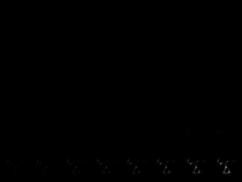

In [9]:
Image(filename=MODEL_PATH + '/z2.png')

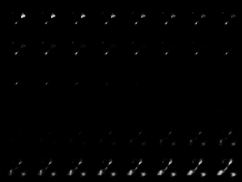

In [10]:
Image(filename=MODEL_PATH + '/z3.png')

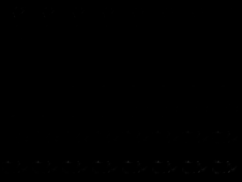

In [11]:
Image(filename=MODEL_PATH + '/z4.png')

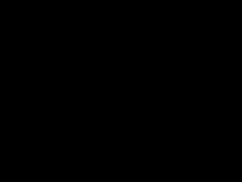

In [12]:
Image(filename=MODEL_PATH + '/z5.png')

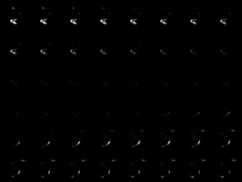

In [13]:
Image(filename=MODEL_PATH + '/z6.png')

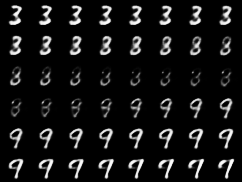

In [14]:
Image(filename=MODEL_PATH + '/z7.png')

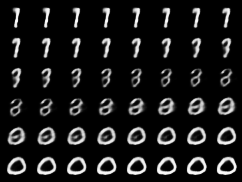

In [15]:
Image(filename=MODEL_PATH + '/z8.png')

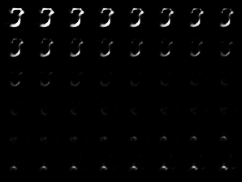

In [16]:
Image(filename=MODEL_PATH + '/z9.png')

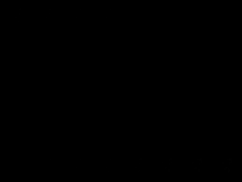

In [17]:
Image(filename=MODEL_PATH + '/z10.png')

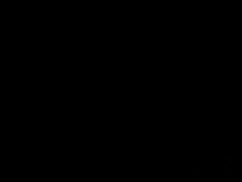

In [18]:
Image(filename=MODEL_PATH + '/z11.png')

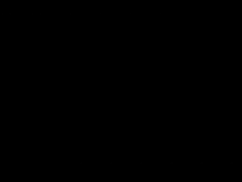

In [19]:
Image(filename=MODEL_PATH + '/z12.png')

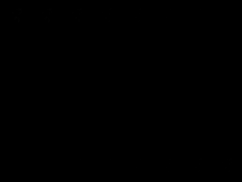

In [20]:
Image(filename=MODEL_PATH + '/z13.png')

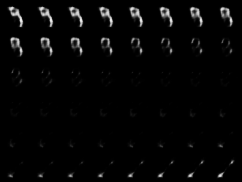

In [21]:
Image(filename=MODEL_PATH + '/z14.png')

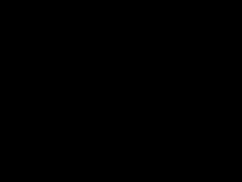

In [22]:
Image(filename=MODEL_PATH + '/z15.png')

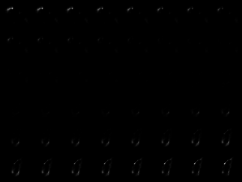

In [23]:
Image(filename=MODEL_PATH + '/z0.png')

### PCA Analysis of Latent Space

In [24]:
n_components = latent.shape[1]

pca = decomposition.PCA(n_components=n_components)
pca.fit(latent)

plt.figure()
plt.plot(pca.explained_variance_ratio_, 'bo')
plt.plot(pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

<IPython.core.display.Javascript object>

In [25]:
max_pts = 1280
l = 3 # plot limits

latent_in_pc = pca.transform(latent)
print(latent_in_pc.shape)

fig = plt.figure(figsize=(8,8))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(latent_in_pc[:max_pts,0],
           latent_in_pc[:max_pts,1],
           latent_in_pc[:max_pts,2],
           c=class_labels[:max_pts], marker='.', cmap=plt.cm.Set1)

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(['class label'])

ax.set_xlim([-l,l])
ax.set_ylim([-l,l])
ax.set_zlim([-l,l])

plt.savefig(MODEL_PATH+'/latent.pdf')
plt.show()

(10000, 16)


<IPython.core.display.Javascript object>

### Direct look at the Jacobian of the resulting network

In [26]:
n_samples = 128
n_outputs = torch.tensor(np.product(original_data.shape[1:]))

J = np.zeros([28*28, latent.shape[1]])
for i in range(n_samples):
    Jx = jacob.jacobian(model.decode, torch.tensor(latent[i]), n_outputs)
    J += Jx.detach().numpy()

In [27]:
J_pca = decomposition.PCA(n_components=J.shape[1])
J_pca.fit(J)

plt.figure()
plt.plot(J_pca.explained_variance_ratio_, 'bo')
plt.plot(J_pca.explained_variance_ratio_, 'b-')
plt.xlabel('component')
plt.ylabel('explained variance (%)')
plt.savefig(MODEL_PATH+'/pca_spectrum.pdf')
plt.show()

<IPython.core.display.Javascript object>

In [28]:
JG = np.dot(J.T, J)

plt.figure()
plt.title('Jacobian-Grammian')
plt.imshow(JG, cmap='seismic', vmin=-.25, vmax=.25)

# for (j,i),label in np.ndenumerate(JG):
#     plt.text(i, j, np.round(label,2), ha='center', va='center', color='w')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>

## Try linear classification on latent space and check performance

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

In [30]:
lr = LogisticRegression(penalty='l2', C=1.0)
cv = ShuffleSplit(n_splits=5, test_size=0.1)

In [31]:
X = original_data.copy().reshape(10000, 28*28)
y = class_labels.numpy()
print(X.shape, y.shape)
cross_val_score(lr, X, y, cv=cv)

(10000, 784) (10000,)


/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/u/xl/tjlane/opt/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:46

array([0.853, 0.891, 0.853, 0.86 , 0.845])

In [32]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

NameError: name 'scores' is not defined

In [ ]:
#lr.predict(X[:2, :])
#lr.predict_proba(X[:2, :])
#lr.score(X, y)